In [488]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
scorer = make_scorer(mean_squared_error, greater_is_better = False)

## Loading train data

In [489]:
train = pd.read_csv('train.csv')
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Airline C,12/06/2019,Delhi,Cochin,DEL → MAA → COK,20:40,09:25 13 Jun,12h 45m,1 stop,No info,7480
1,Airline A,18/06/2019,Banglore,Delhi,BLR → DEL,18:55,22:00,3h 5m,non-stop,No info,8016
2,Airline C,18/05/2019,Delhi,Cochin,DEL → BOM → COK,03:50,19:15,15h 25m,1 stop,No info,8879
3,Airline A,6/05/2019,Kolkata,Banglore,CCU → BOM → BLR,20:00,08:15 07 May,12h 15m,1 stop,In-flight meal not included,9663
4,Airline A,9/05/2019,Kolkata,Banglore,CCU → BOM → BLR,06:30,12:00,5h 30m,1 stop,In-flight meal not included,9663


## loading test data

In [490]:
test = pd.read_csv('test.csv')
test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Airline B,27-03-2019,Delhi,Cochin,DEL → HYD → COK,04:55,16:10,11h 15m,1 stop,No info
1,Airline E,27-05-2019,Kolkata,Banglore,CCU → BLR,22:20,28-05-2020 00:40,2h 20m,non-stop,No info
2,Airline C,06-06-2019,Kolkata,Banglore,CCU → IXR → DEL → BLR,05:50,20:25,14h 35m,2 stops,No info
3,Airline A,06-03-2019,Banglore,New Delhi,BLR → MAA → DEL,09:45,14:25,4h 40m,1 stop,No info
4,Airline B,15-06-2019,Delhi,Cochin,DEL → BOM → COK,16:00,16-06-2020 01:30,9h 30m,1 stop,No info


### null value check for train and test data

In [491]:
train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [492]:
test.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

### dropping null values

In [493]:
train = train.dropna()

### getting an overview of data

In [494]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8011 entries, 0 to 8011
Data columns (total 11 columns):
Airline            8011 non-null object
Date_of_Journey    8011 non-null object
Source             8011 non-null object
Destination        8011 non-null object
Route              8011 non-null object
Dep_Time           8011 non-null object
Arrival_Time       8011 non-null object
Duration           8011 non-null object
Total_Stops        8011 non-null object
Additional_Info    8011 non-null object
Price              8011 non-null int64
dtypes: int64(1), object(10)
memory usage: 751.0+ KB


In [495]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
Airline            2671 non-null object
Date_of_Journey    2671 non-null object
Source             2671 non-null object
Destination        2671 non-null object
Route              2671 non-null object
Dep_Time           2671 non-null object
Arrival_Time       2671 non-null object
Duration           2671 non-null object
Total_Stops        2671 non-null object
Additional_Info    2671 non-null object
dtypes: object(10)
memory usage: 208.8+ KB


### finding unique value counts in train and test data

In [496]:
for i in train.columns:
    print("Unique values in", i, train[i].nunique())

Unique values in Airline 12
Unique values in Date_of_Journey 44
Unique values in Source 5
Unique values in Destination 6
Unique values in Route 122
Unique values in Dep_Time 219
Unique values in Arrival_Time 1182
Unique values in Duration 353
Unique values in Total_Stops 4
Unique values in Additional_Info 10
Unique values in Price 1632


In [497]:
for i in test.columns:
    print("Unique values in", i, test[i].nunique())

Unique values in Airline 9
Unique values in Date_of_Journey 40
Unique values in Source 5
Unique values in Destination 6
Unique values in Route 96
Unique values in Dep_Time 196
Unique values in Arrival_Time 697
Unique values in Duration 321
Unique values in Total_Stops 5
Unique values in Additional_Info 6


### creating a new column Days_bfr_journey, the ticket was booked


In [498]:

train_new = train.copy() 
train_new['Day_of_Booking'] = '1/1/2019'
train_new['Day_of_Booking'] = pd.to_datetime(train_new['Day_of_Booking'],format='%d/%m/%Y')
train_new['Date_of_Journey'] = pd.to_datetime(train_new['Date_of_Journey'],format='%d/%m/%Y')
train_new['Days_to_Departure'] = (train_new['Date_of_Journey'] - train_new['Day_of_Booking']).dt.days
train['Days_bfr_journey'] = train_new['Days_to_Departure']

In [499]:
test_new = test.copy() 
test_new['Day_of_Booking'] = '1/1/2019'
test_new['Day_of_Booking'] = pd.to_datetime(test_new['Day_of_Booking'],format='%d/%m/%Y')
test_new['Date_of_Journey'] = pd.to_datetime(test_new['Date_of_Journey'],format='%d-%m-%Y')
test_new['Days_to_Departure'] = (test_new['Date_of_Journey'] - test_new['Day_of_Booking']).dt.days
test['Days_bfr_journey'] = test_new['Days_to_Departure']

### removing date from Arrival_Time column

In [500]:
train['Arrival_Time'] = train['Arrival_Time'].str.split(' ').str[0]
test['Arrival_Time'] = test['Arrival_Time'].str.split(' ').str[-1]

In [501]:
## dropping row 1054 since unwanted format value is present

train = train.drop([train.index[1054]])

### Creating a new feature Duration where converting hours in minutes format both for train and test data

In [502]:
train['Hours'] = train['Duration'].str.split(' ').str[0]
train['Hours'] = train['Hours'].str.replace('h','')
train['Hours'] = train['Hours'].astype(float)

train['Minutes'] = train['Duration'].str.split(' ').str[1]
train['Minutes'] = train['Minutes'].str.replace('m','').astype(float)


test['Hours'] = test['Duration'].str.split(' ').str[0]
test['Hours'] = test['Hours'].str.replace('h','')
test['Hours'] = test['Hours'].astype(float)

test['Minutes'] = test['Duration'].str.split(' ').str[1]
test['Minutes'] = test['Minutes'].str.replace('m','').astype(float)

In [503]:
train['Hours'] = train['Hours'] * 60
train['Duration'] = train['Hours'] + train['Minutes']

test['Hours'] = test['Hours'] * 60
test['Duration'] = test['Hours'] + test['Minutes']

train.drop(['Hours', 'Minutes'], axis=1, inplace=True)
test.drop(['Hours', 'Minutes'], axis=1, inplace=True)

### plotting graphs for various features

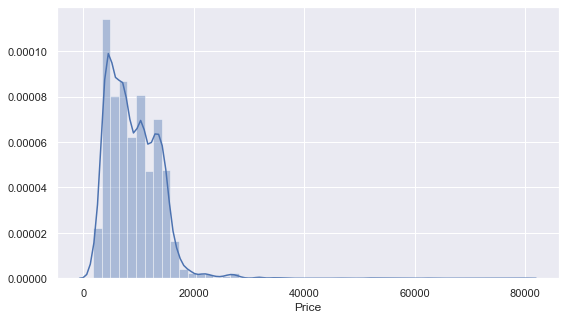

In [504]:
# looking at price distribution of the data

plt.figure(figsize=(9,5))
sns.distplot(train.Price)
plt.show()

### removing outliers from Price column

<AxesSubplot:ylabel='Price'>

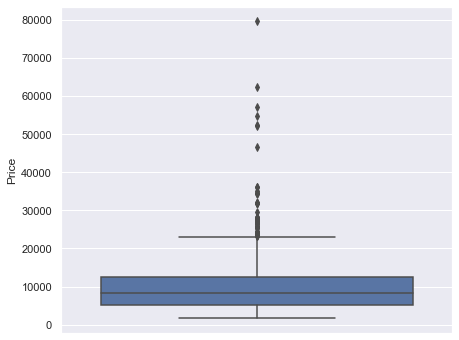

In [505]:
plt.figure(figsize=(7,6))
sns.boxplot(y='Price', data=train )

<AxesSubplot:ylabel='Price'>

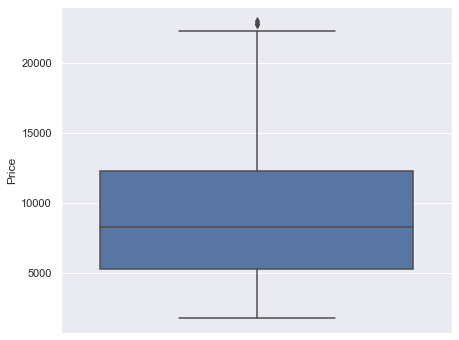

In [506]:
train = train[train['Price']<23000]

plt.figure(figsize=(7,6))
sns.boxplot(y='Price', data=train ) 

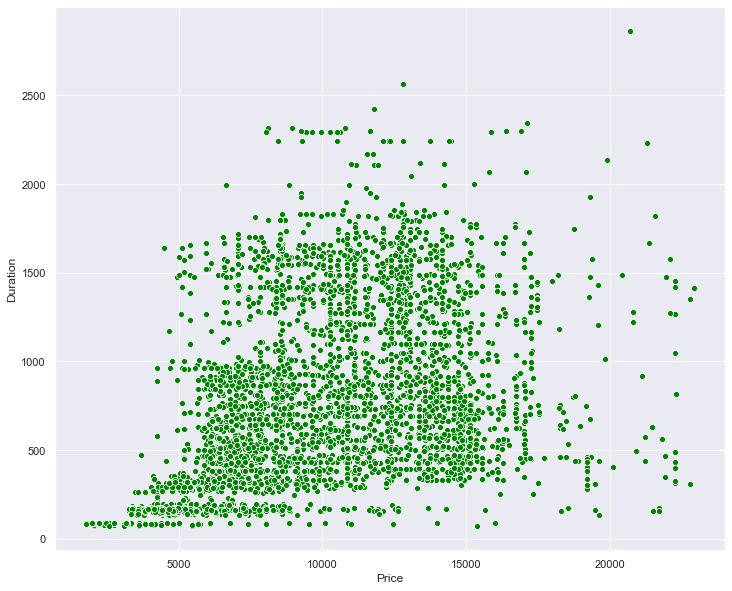

In [507]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=train, x='Price',y='Duration',color='green')
plt.show()

# plt.figure(figsize=(9,5))
# plt.scatter(train['Price'], train['Duration'])
# plt.xlabel('Price')
# plt.ylabel('Duration')
# plt.show()

In [508]:
train.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Days_bfr_journey'],
      dtype='object')

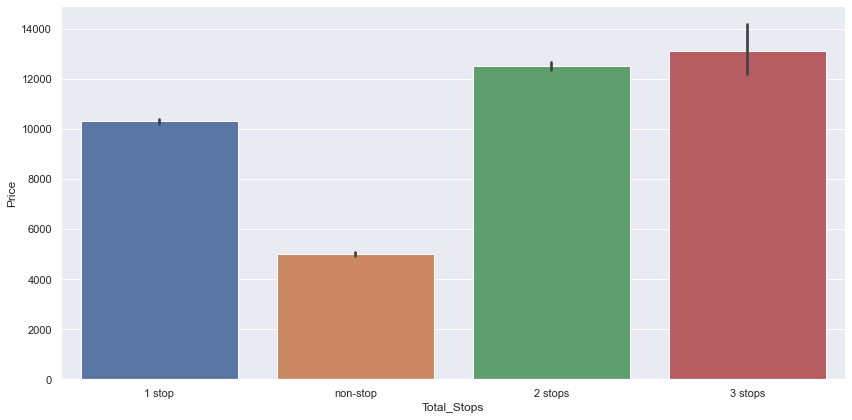

In [509]:
sns.set(style="darkgrid")
sns.catplot(
    data=train,
    x='Total_Stops',
    y='Price',
    
    kind='bar',
    height=6, # make the plot 5 units high
    aspect=2)

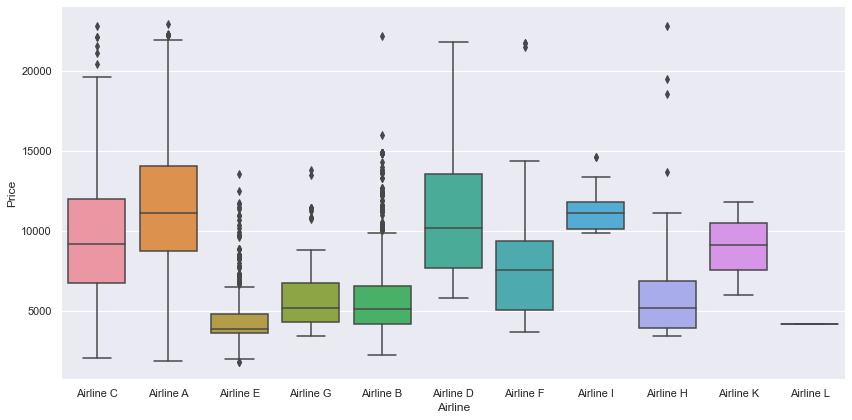

In [510]:
sns.set(style="darkgrid")
sns.catplot(
    data=train,
    x='Airline',
    y='Price',
    
    kind='box',
    height=6, # make the plot 5 units high
    aspect=2)

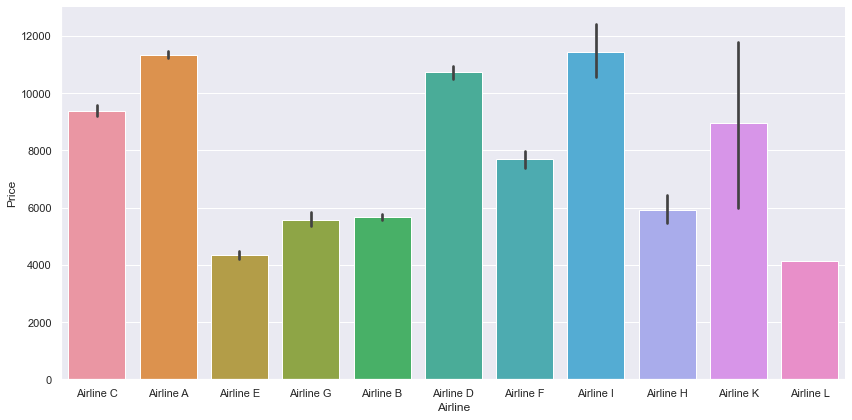

In [511]:
sns.catplot(
    data=train,
    x='Airline',
    y='Price',
    
    kind='bar',
    height=6, # make the plot 5 units high
    aspect=2,
    )

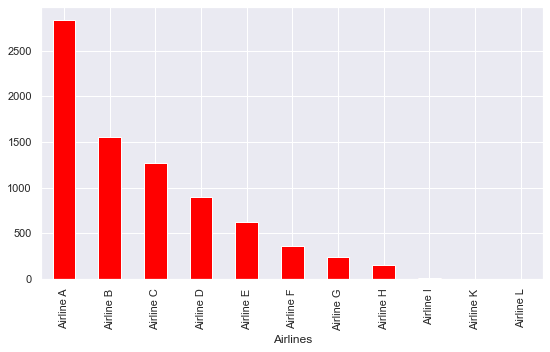

In [512]:
plt.figure(figsize=(9,5))
train['Airline'].value_counts().plot.bar(color='red')
plt.xlabel('Airlines')
plt.show()

<AxesSubplot:>

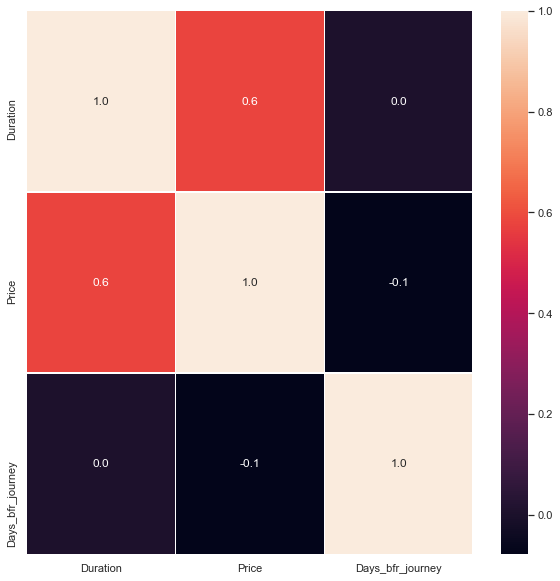

In [513]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train.corr(),annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [514]:
train['Price'] = np.log1p(train['Price'])

train['Duration'] = np.log1p(train['Duration'])
train['Duration'] = np.log1p(train['Days_bfr_journey'])

test['Duration'] = np.log1p(test['Duration'])
test['Duration'] = np.log1p(test['Days_bfr_journey'])


In [515]:
train = train.drop('Route',1)
test = test.drop('Route',1)

In [516]:
train.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Days_bfr_journey
0,Airline C,12/06/2019,Delhi,Cochin,20:40,09:25,5.093750,1 stop,No info,8.920122,162
1,Airline A,18/06/2019,Banglore,Delhi,18:55,22:00,5.129899,non-stop,No info,8.989320,168
2,Airline C,18/05/2019,Delhi,Cochin,03:50,19:15,4.927254,1 stop,No info,9.091557,137
3,Airline A,6/05/2019,Kolkata,Banglore,20:00,08:15,4.836282,1 stop,In-flight meal not included,9.176163,125
4,Airline A,9/05/2019,Kolkata,Banglore,06:30,12:00,4.859812,1 stop,In-flight meal not included,9.176163,128


In [517]:
#converting all categorical values using get_dummies to numerical

train['label'] = 'train'
test['label'] = 'test'

concat_df = pd.concat([train,test])

features_df = pd.get_dummies(concat_df, columns=['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Dep_Time','Arrival_Time', 'Total_Stops', 'Additional_Info'], drop_first=True)

# train = pd.get_dummies(train, columns=['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Dep_Time',
#        'Arrival_Time', 'Total_Stops', 'Additional_Info'],drop_first=True)

# test = pd.get_dummies(test, columns=['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Dep_Time',
#        'Arrival_Time', 'Total_Stops', 'Additional_Info'],drop_first=True)

train = features_df[features_df['label']=='train']
test = features_df[features_df['label']=='test']

train = train.drop('label',1)
test = test.drop('label',1)

In [518]:
train.head()

,Days_bfr_journey,Duration,Price,Airline_Airline B,Airline_Airline C,Airline_Airline D,Airline_Airline E,Airline_Airline F,Airline_Airline G,Airline_Airline H,...,Total_Stops_3 stops,Total_Stops_4 stops,Total_Stops_non-stop,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight
0,162,5.093750,8.920122,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,168,5.129899,8.989320,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,137,4.927254,9.091557,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,125,4.836282,9.176163,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,128,4.859812,9.176163,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [519]:
print(train.shape, test.shape)

(7937, 559) (2671, 559)


In [520]:
#model building

X = train.drop('Price',1)
y = train['Price']

In [521]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=0)

In [522]:
from sklearn.ensemble import BaggingRegressor
br = BaggingRegressor(base_estimator=None, 
                      n_estimators=50, 
                      max_samples=1.0, 
                      max_features=1.0, 
                      bootstrap=True, 
                      bootstrap_features=False, 
                      oob_score=False, 
                      warm_start=False, 
                      n_jobs=1, 
                      random_state=1, 
                      verbose=0)
br.fit(X_train, y_train)
y_pred1 = br.predict(X_test)
print('RMSLE:', np.sqrt(mean_squared_error(y_test,y_pred1)))

xgbaccuracy= r2_score(y_test, y_pred1)
print(xgbaccuracy)

RMSLE: 0.12187275262906397
0.9393939641597225


In [523]:
rf_clf1 = RandomForestRegressor(max_depth=2, random_state=2)
rf_clf1.fit(X_train, y_train)

prediction1 = rf_clf1.predict(X_test)


rmse_rd = np.sqrt(mean_squared_error(y_test, prediction1))
print(rmse_rd)

rfaccuracy= r2_score(y_test, prediction1)
print(rfaccuracy)

0.30524856956151164
0.6198019258068183


In [524]:
from sklearn.ensemble import GradientBoostingRegressor

gb_clf = GradientBoostingRegressor(random_state=0)

gb_clf.fit(X_train, y_train)
gb_score = gb_clf.predict(X_test)

rmsee = np.sqrt(mean_squared_error(y_test, gb_score))
print(rmsee)

r2_score(y_test, gb_score)

0.19435196878880406


0.8458723606905689

In [525]:
gb = GradientBoostingRegressor(loss='ls', 
                               learning_rate=0.3, 
                               n_estimators=150, 
                               subsample=1.0, 
                               criterion='friedman_mse', 
                               min_samples_split=30, 
                               min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, 
                               max_depth=7, 
                               min_impurity_decrease=0.0, 
                               min_impurity_split=None, 
                               init=None, 
                               random_state=0, 
                               max_features=None, 
                               alpha=0.9, 
                               verbose=100, 
                               max_leaf_nodes=None, 
                               warm_start=False, 
                               presort='auto')

gb.fit(X_train, y_train)
y_pred2 = gb.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred2))

      Iter       Train Loss   Remaining Time 
         1           0.1472           14.80s
         2           0.0939           16.65s
         3           0.0641           16.84s
         4           0.0492           16.40s
         5           0.0389           17.18s
         6           0.0336           18.04s
         7           0.0294           17.89s
         8           0.0273           18.58s
         9           0.0249           18.54s
        10           0.0226           18.84s
        11           0.0217           19.06s
        12           0.0202           18.94s
        13           0.0196           19.29s
        14           0.0192           19.37s
        15           0.0186           19.59s
        16           0.0182           19.46s
        17           0.0179           19.28s
        18           0.0173           19.36s
        19           0.0169           19.41s
        20           0.0166           19.37s
        21           0.0164           19.36s
        2

In [526]:
rmse_gb

grb_acc = r2_score((y_test), (y_pred2))
print(grb_acc, rmse_gb)

0.9340535134210516 0.12712896533962764


In [527]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=9, 
                   learning_rate=0.5, 
                   n_estimators=112, 
                   silent=False, 
                   objective='reg:squarederror', 
                   booster='gbtree', 
                   n_jobs=1, 
                   nthread=None, 
                   gamma=0, 
                   min_child_weight=1, 
                   max_delta_step=0, 
                   subsample=1, 
                   colsample_bytree=1, 
                   colsample_bylevel=1, 
                   reg_alpha=1, 
                   reg_lambda=1, 
                   scale_pos_weight=1, 
                   base_score=0.5, 
                   random_state=0, 
                   seed=None)
xgb.fit(X_train, y_train)
y_pred3 = xgb.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test,y_pred3 ))
print(xgb_rmse)
print(r2_score(y_test, y_pred3))

0.12545040903926016
0.935783474902697


## prediction on test set

In [528]:
test = test.drop('Price',1)

In [529]:
final_1 = gb.predict(test)
output = pd.DataFrame(data = np.exp(final_1), columns=['Price'])
#output = output['Price'].astype(int)
output.to_csv('third_sub.csv', index=False)
output